# **P**rincipal **O**rthogonal **L**atent **C**omponents **A**nalysis Net (POLCA-Net)

In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt

In [1]:
import numpy as np
import torch
import torchinfo
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
import polcanet.reports as report
import polcanet.utils as ut
from polcanet import PolcaNet

Current default figure size: [3.5, 2.625]
New default figure size: [5.25, 3.9375]


In [3]:
import random

random_seed = 5
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
with_labels = True
if with_labels:
    name = "MNIST_dataset_labels"
else:
    name = "MNIST_dataset"
    
exp = ut.ExperimentInfoHandler(
    name=name,
    description="POLCA-Net on MNIST dataset",
    random_seed=random_seed,
)
ut.set_save_fig(True)
ut.set_save_path(str(exp.get_experiment_folder()))
print(f"Saving Images: {ut.get_save_fig()}, saving in path: {ut.get_save_path()}")

Saving Images: True, saving in path: /data1/deploy/polcanet/examples/notebooks/experiments/MNIST_dataset_labels


### Load dataset

In [4]:
from torchvision.datasets import MNIST
mnist_trainset = MNIST(root="data/MNIST", train=True, download=True, transform=None)
mnist_testset = MNIST(root="data/MNIST", train=False, download=True, transform=None)

In [5]:
train_dataset = mnist_trainset.data.reshape(-1, 28, 28) / 255.0
eval_dataset = mnist_testset.data.reshape(-1, 28, 28) / 255.0
y = mnist_trainset.targets.numpy()
y_test = mnist_testset.targets.numpy()

labels = np.unique(y) if with_labels else None

X = np.array(train_dataset.numpy(), dtype=np.float32)
X = np.squeeze(X)
print(X.min(),X.max())
X_test = np.array(eval_dataset.numpy(), dtype=np.float32)
X_test = np.squeeze(X_test)
train_dataset.shape, eval_dataset.shape, X.shape,X_test.shape, y.shape, y_test.shape, labels

0.0 1.0


(torch.Size([60000, 28, 28]),
 torch.Size([10000, 28, 28]),
 (60000, 28, 28),
 (10000, 28, 28),
 (60000,),
 (10000,),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

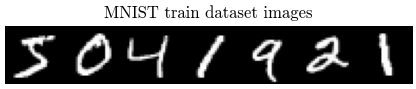

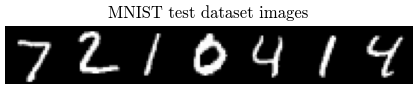

In [6]:
ut.set_fig_prefix("sin_train")
ut.plot_train_images(X, "MNIST train dataset images",cmap="gray", n=7)
ut.set_fig_prefix("sin_test")
ut.plot_train_images(X_test, "MNIST test dataset images",cmap="gray", n=7)

### Fit standard sklearn PCA

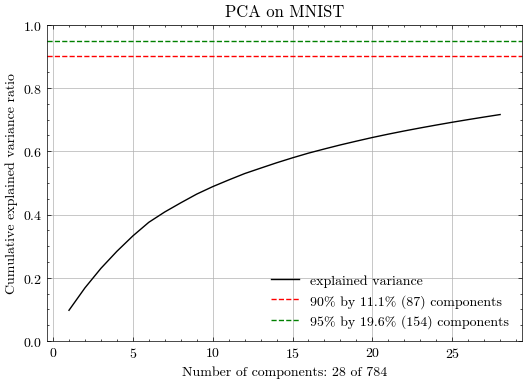

In [10]:
n_components = 28 #  Heuristic sqrt(image size)
fig, axs = plt.subplots(1,1,sharex=True, sharey=True,layout='constrained')
pca = ut.get_pca(X,n_components=n_components,title="PCA on MNIST",ax=axs,)
Xpca = pca.transform(np.squeeze(X.reshape(X.shape[0], -1)))
plt.show()

### Fit POLCANet

In [11]:
N = X[0].shape[0]
M = X[0].shape[1]

In [14]:
from polcanet.aencoders import ConvEncoder, LinearDecoder

act_fn = torch.nn.SiLU
input_dim = (N, M)
latent_dim = pca.n_components
assert N == input_dim[0], "input_dim[0] should match first matrix dimension N"
assert M == input_dim[1], "input_dim[1] should match second matrix dimension M"


encoder = ConvEncoder(
    input_channels=1,
    latent_dim=latent_dim,
    conv_dim=2,
    initial_channels=8,
    growth_factor=2,
    num_layers=5,
    act_fn=act_fn,
)

decoder = LinearDecoder(
    latent_dim=latent_dim,
    input_dim=input_dim,
    hidden_dim=512,
    num_layers=5,
    act_fn=act_fn,
    bias=False,
)

model = PolcaNet(
    encoder=encoder,
    decoder=decoder,
    latent_dim=latent_dim,
    alpha=1.0,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=1.0,  # variance reduction loss
    class_labels=labels,  # class labels for supervised in case labels is not None
)

print(model)
summary = torchinfo.summary(
    model,
    (1, input_dim[0], input_dim[1]),
    dtypes=[torch.float],
    verbose=1,
    col_width=16,
    col_names=["kernel_size", "output_size", "num_params"],
    row_settings=["var_names"],
)
ut.save_text(str(model), "model.txt")
ut.save_text(str(summary), "model_summary.txt")

PolcaNet(
  (encoder): EncoderWrapper(
    (encoder): Sequential(
      (0): ConvEncoder(
        (encoder): Sequential(
          (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): SiLU()
          (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (3): SiLU()
          (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (5): SiLU()
          (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (7): SiLU()
          (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (9): SiLU()
          (10): Flatten(start_dim=1, end_dim=-1)
          (11): Linear(in_features=128, out_features=112, bias=True)
          (12): SiLU()
          (13): Linear(in_features=112, out_features=28, bias=True)
        )
      )
      (1): Softsign()
    )
    (classifier): Linear(in_features=28, out_features=10, bias=True)
  )
  (decoder): LinearDecoder(
    (decod

In [15]:
model.to(device)
model.train_model(data=X,y=y,batch_size=512, num_epochs=5000, report_freq=10, lr=1e-3)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 5000
Total Loss: 0.01144
Reconstruction Loss: 0.006174
Orthogonality Loss: 0.002493
Center of Mass Loss: 0.001375
Variance Reduction Loss: 0.001303
Classification Loss: 9.341e-05


np.float64(0.011438572550413468)

In [17]:
model.train_model(data=X,y=y,batch_size=512, num_epochs=5000, report_freq=10, lr=1e-4)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 5000
Total Loss: 0.006815
Reconstruction Loss: 0.004057
Orthogonality Loss: 0.001505
Center of Mass Loss: 0.0005616
Variance Reduction Loss: 0.0006114
Classification Loss: 7.957e-05


np.float64(0.006815331356631497)

In [18]:
model.train_model(data=X,y=y, batch_size=512, num_epochs=5000, report_freq=10, lr=1e-5)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 5000
Total Loss: 0.006287
Reconstruction Loss: 0.003842
Orthogonality Loss: 0.001332
Center of Mass Loss: 0.0004793
Variance Reduction Loss: 0.0005512
Classification Loss: 8.258e-05


np.float64(0.006286538111330089)

## Evaluate results

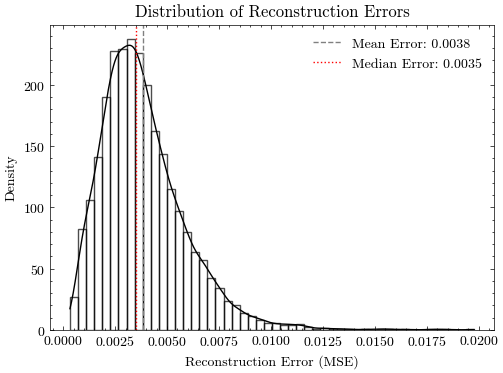

Mean Reconstruction Error: 0.0038
Median Reconstruction Error: 0.0035
Min Reconstruction Error: 0.0003
Max Reconstruction Error: 0.0198


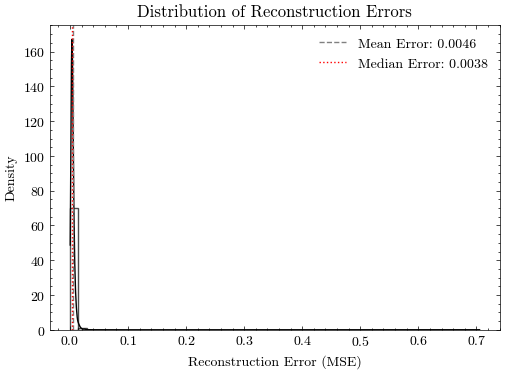

Mean Reconstruction Error: 0.0046
Median Reconstruction Error: 0.0038
Min Reconstruction Error: 0.0003
Max Reconstruction Error: 0.7055


In [29]:
ut.set_fig_prefix("train")
report.analyze_reconstruction_error(model, X)
ut.set_fig_prefix("test")
report.analyze_reconstruction_error(model, X_test)

In [30]:
latents, reconstructed = model.predict(X)

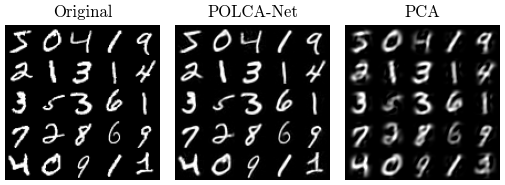

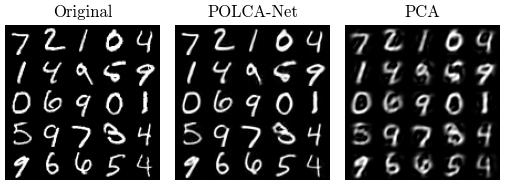

In [31]:
# Assuming images are properly defined as before
images = X[0:25]
ut.set_fig_prefix("train")
ut.plot_reconstruction_comparison(model,pca,images,cmap="gray",nrow=5)
images = X_test[0:25]
ut.set_fig_prefix("test")
ut.plot_reconstruction_comparison(model,pca,images,cmap="gray",nrow=5)


    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: -0.0005
    - Max cosine similarity: 0.0884
    - Min cosine similarity: -0.0833
    


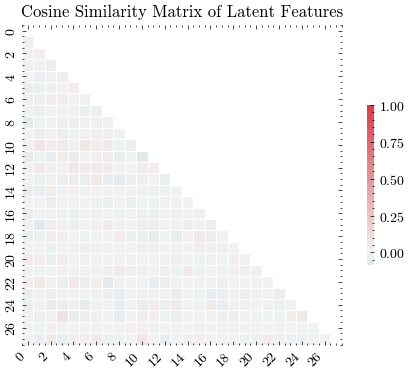

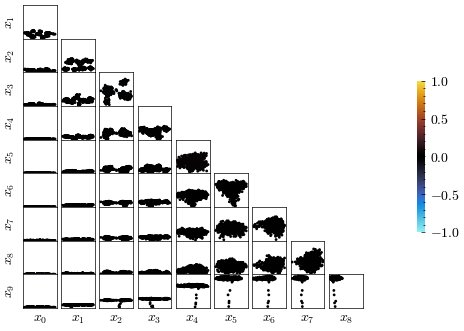


    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: 0.0026
    - Max cosine similarity: 0.0975
    - Min cosine similarity: -0.1350
    


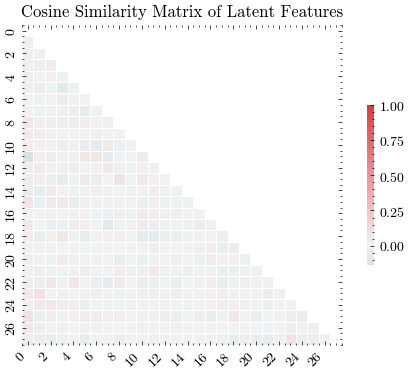

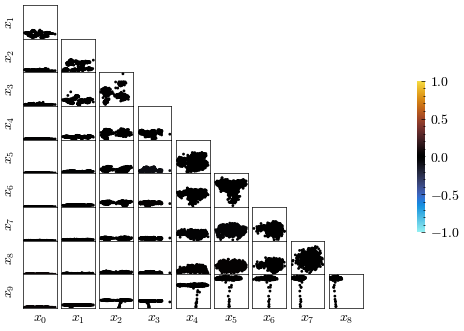

In [32]:
ut.set_fig_prefix("train")
report.orthogonality_test_analysis(model, X)
ut.set_fig_prefix("test")
report.orthogonality_test_analysis(model, X_test)


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 1.1391
    - Variance fit to exponential distribution (sum of squared differences):
     0.1043
    


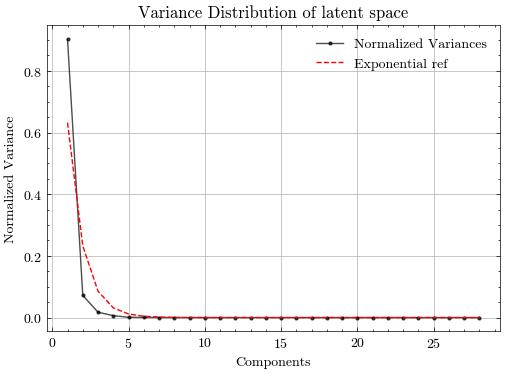

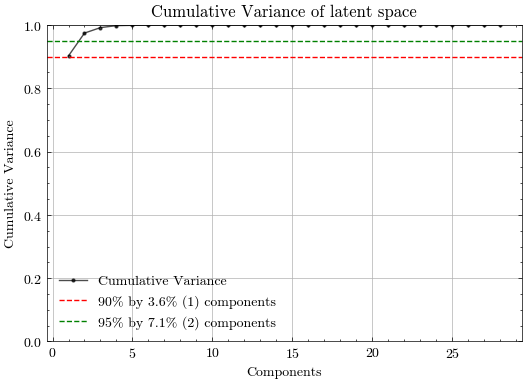

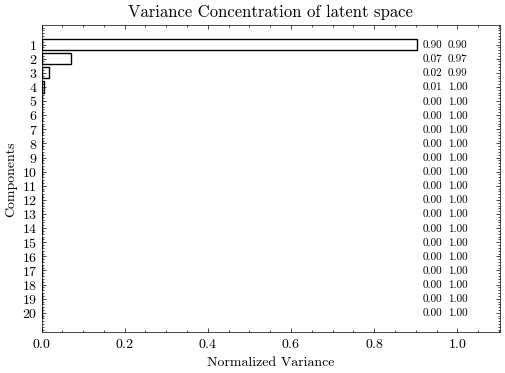


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 1.1535
    - Variance fit to exponential distribution (sum of squared differences):
     0.0966
    


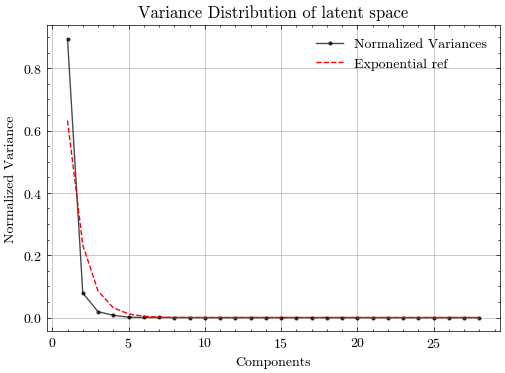

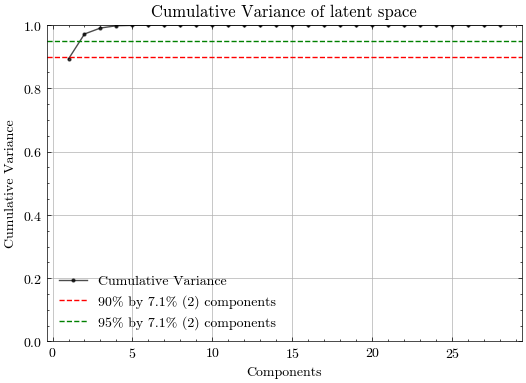

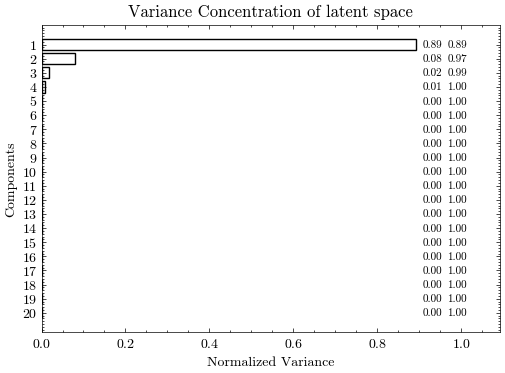

In [33]:
ut.set_fig_prefix("train")
report.variance_test_analysis(model, X)
ut.set_fig_prefix("test")
report.variance_test_analysis(model, X_test)

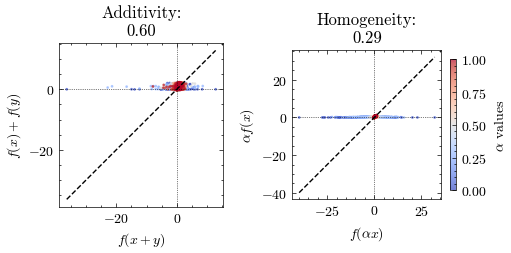

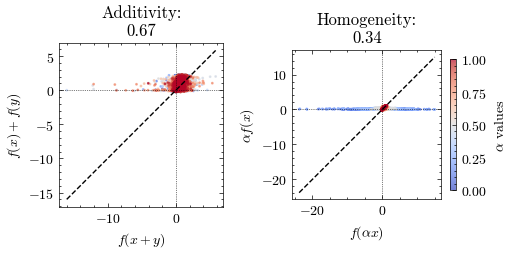

In [35]:
ut.set_fig_prefix("train")
report.linearity_tests_analysis(model, X,alpha_min=0, num_samples=200)
ut.set_fig_prefix("test")
report.linearity_tests_analysis(model, X_test,alpha_min=0, num_samples=200)

In [36]:
o1 = widgets.Output()
o2 = widgets.Output()
with o1:
    _, _ = ut.plot2d_analysis(Xpca, y, title="PCA transform", legend=True)
with o2:
    _, _ = ut.plot2d_analysis(latents, y, title="POLCA-Net latent",  legend=True)
layout = widgets.Layout(grid_template_columns="repeat(2, 600px)")
accordion = widgets.GridBox(children=[o1, o2], layout=layout)
display(accordion)

GridBox(children=(Output(), Output()), layout=Layout(grid_template_columns='repeat(2, 600px)'))

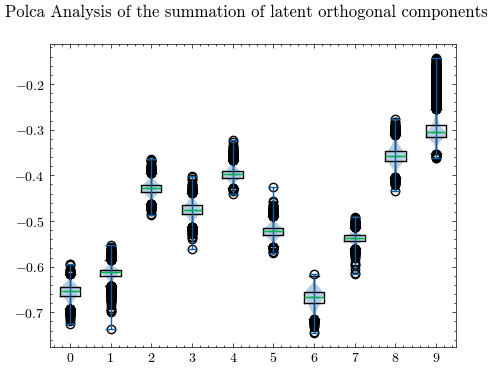

In [37]:
latents, reconstructed = model.predict(X)
vectors = []
labels = [str(i) for i in range(10)]
for c, label in enumerate(labels):
    vectors.append(np.sum(latents[y == c, :], axis=1))


plt.boxplot(vectors, tick_labels=labels)
plt.violinplot(vectors, showmeans=False, showmedians=True)
plt.suptitle("Polca Analysis of the summation of latent orthogonal components")
plt.show()

## Test Classification with two components on PCA vs POLCA Net

In [38]:
_ = ut.make_classification_report(model, pca, X_test, y_test, n_components=pca.n_components)

output shape from pca (7000, 28) (3000, 28)
output shape from POLCA (7000, 28) (3000, 28)


/data1/conda/envs/python3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Performance Metrics DataFrame:


/data1/conda/envs/python3.12/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/data1/conda/envs/python3.12/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/data1/conda/envs/python3.12/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/data1/conda/envs/python3.12/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Accuracy       Error rate       Matthews       F1-Score  \
Transformation            PCA POLCA        PCA POLCA      PCA POLCA      PCA   
Classifier                                                                     
Gaussian Naive Bayes     0.84  0.99      16.20  1.03     0.82  0.99     0.84   
Linear SVM               0.88  0.99      12.37  0.93     0.86  0.99     0.87   
Logistic Regression      0.86  0.99      14.03  1.00     0.85  0.99     0.86   
Perceptron               0.76  0.99      23.63  1.30     0.75  0.99     0.75   
Ridge Classifier         0.81  0.99      18.93  1.43     0.79  0.98     0.80   

                            
Transformation       POLCA  
Classifier                  
Gaussian Naive Bayes  0.99  
Linear SVM            0.99  
Logistic Regression   0.99  
Perceptron            0.99  
Ridge Classifier      0.99


Wilcoxon Signed-Rank Test Results DataFrame:


,Wilcoxon Test,P-Value,Significant (p < 0.05)
Accuracy,0.0,0.0625,No better method
Error rate,0.0,0.0625,No better method
Matthews,0.0,0.0625,No better method
F1-Score,0.0,0.0625,No better method


In [39]:
experiment_data = {
    "MNIST": (
        X_test,
        model,
        pca,
    ),
}
_ = ut.image_metrics_table(experiment_data)

,NMSE,PSNR,SSI
Method,,,
POLCA MNIST,0.0425,24.3248,0.9230
PCA MNIST,0.1771,17.6297,0.6405
